In [6]:
!pip install torchsde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 10.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [28]:
!pip install torch==2.0.1+cu118 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 448.5 kB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 31.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+rocm5.6
    Uninstalling torch-2.1.0+rocm5.6:
      Successfully uninstalled torch-2.1.0+rocm5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.6.5 requires protobuf<=3.20.1, but you have protobuf 3.20.3 which is incompatible.
pytorch-lightning 1.6.5 requires PyYAML>=5.4, but you have pyyaml 5.3.1 which is incompatible.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 2.0.1+cu118 which is incompatible.
torchvision 0.14.0+cu116 requires torch==1.13.0, but you have torch 2.0.1+cu118 which is incompatible.

[notice] A new r

In [12]:
from typing import Union

import chex
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchsde

from typing import Tuple, Optional

import jax.numpy as jnp
import chex


def get_senders_and_receivers_fully_connected(n_nodes: int) -> Tuple[chex.Array, chex.Array]:
    receivers = []
    senders = []
    for i in range(n_nodes):
        for j in range(n_nodes - 1):
            receivers.append(i)
            senders.append((i + 1 + j) % n_nodes)
    return torch.tensor(senders), torch.tensor(receivers)

def energy(x: torch.Tensor, epsilon: float = 1.0, tau: float = 1.0, r: Union[float, chex.Array] = 1.0,
           harmonic_potential_coef: float = 0.5) -> chex.Array:
    n_nodes, dim = x.shape
    if isinstance(r, float):
        r = torch.ones(n_nodes, device=device) * r
    senders, receivers = get_senders_and_receivers_fully_connected(n_nodes)
    vectors = x[senders] - x[receivers]
    d = torch.linalg.norm(vectors, ord=2, dim=-1)
    term_inside_sum = (r[receivers] / d)**12 - 2*(r[receivers] / d)**6
    energy = epsilon / (2 * tau) * term_inside_sum.sum()

    # For harmonic potential see https://github.com/vgsatorras/en_flows/blob/main/deprecated/eqnode/test_systems.py#L94.
    # This oscillator is mentioned but not explicity specified in the paper where it was introduced:
    # http://proceedings.mlr.press/v119/kohler20a/kohler20a.pdf.
    centre_of_mass = x.mean(dim=0)
    harmonic_potential = harmonic_potential_coef * (x - centre_of_mass).pow(2).sum()
    return energy + harmonic_potential


def log_prob_fn(x: torch.Tensor):
    x = x.reshape(-1, 13, 3)
    if len(x.shape) == 2:
        return - energy(x)
    elif len(x.shape) == 3:
        return - torch.vmap(energy)(x)
    else:
        raise Exception


def plot_sample_hist(samples, ax = None, dim=(0,1)):
    if ax == None:
        fig, ax = plt.subplots()
    d = torch.linalg.norm(samples[:, 0, dim] - samples[:, 1, dim], dim=-1)
    ax.hist(d, bins=50, density=True, alpha=0.4)

In [2]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score_net):
        super().__init__()
        self.score_model = score_net
    
    def f(self, t, x):
        # pdb.set_trace()
        t = t.repeat(len(x)).to(x.device)
        score = self.score_model(x, 1-t)
        return self.g(t, x).pow(2) * score 
    
    def g(self, t, x):
        return torch.full_like(x, beta ** 0.5) #+ 0.1

def estimate_grad_Rt(x, t, beta=1.0, num_mc_samples=100):
    def grad_fxn(_x, _t):
        repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        h_t = beta * repeated_t
        
        # samples = repeated_x + torch.normal(torch.zeros_like(repeated_x), h_t.unsqueeze(1) ** 0.5)
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * h_t.unsqueeze(1) ** 0.5
        log_rewards = log_prob_fn(samples)#unnormalize(samples, global_mins, global_maxs))
        
        return torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    
    t = t * torch.ones(x.shape[0]).to(device)
    est_scores = torch.vmap(torch.func.grad(grad_fxn), randomness='different')(x, t)
    return est_scores

In [7]:
def est_ve_score_wrapper(x, t):
    with torch.enable_grad():
        est_score = estimate_grad_Rt(x, t, beta=beta, num_mc_samples=100)
        return est_score

ve_sde_est_score = VEReverseSDE(est_ve_score_wrapper)

beta = 10

dim = 13 * 3
device = 'cuda'
centers = torch.zeros((100, dim), device=device)
x1_samples = torch.normal(centers, torch.full_like(centers, fill_value=beta))

In [8]:
t = torch.linspace(0.0, 1.0, 500)
with torch.no_grad():
    est_samples = torchsde.sdeint(ve_sde_est_score, x1_samples, t, method='euler')

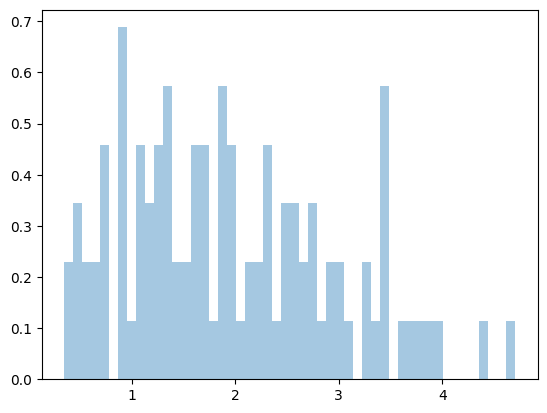

In [15]:
fig, ax = plt.subplots()  # 2D
plot_sample_hist(est_samples[-1].reshape(-1, 13, 3).detach().cpu(), ax=ax)

#ax.plot(d, jnp.exp(log_probs - 1))  # approx normalise

(array([ 1.,  0.,  2.,  0.,  1.,  4., 18., 29., 33., 12.]),
 array([-63.91796875, -57.66281509, -51.40766144, -45.15250778,
        -38.89735413, -32.64220047, -26.38704681, -20.13189316,
        -13.8767395 ,  -7.62158585,  -1.36643219]),
 <BarContainer object of 10 artists>)

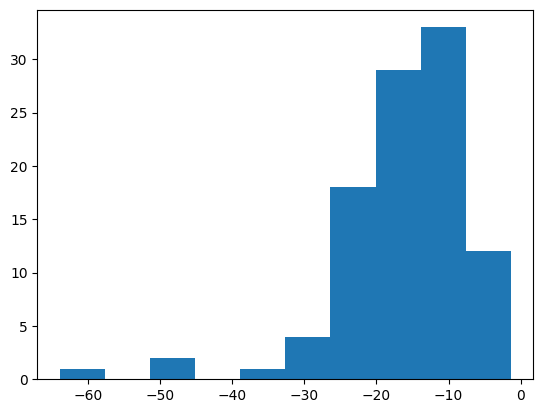

In [19]:
plt.hist(log_prob_fn(est_samples[-1]).detach().cpu())

In [ ]:
if __name__ == '__main__':
    USE_64_BIT = False
    if USE_64_BIT:
        from jax.config import config
        config.update("jax_enable_x64", True)


    # Visualise 2D energy fn as a function of distance
    key = jax.random.PRNGKey(0)

    dim = 2
    batch_size = 512
    x0 = jax.random.normal(jax.random.PRNGKey(0), (batch_size, 2))   #  jnp.zeros((batch_size, 2)) + 0.1
    d = jnp.linspace(0.8, 10, batch_size)
    x1 = x0 + jnp.sqrt(d**2/2)[:, None]

    x = jnp.stack([x0, x1], axis=1)
    log_probs = log_prob_fn(x)

    print(jax.grad(log_prob_fn)(x[0]))

    plt.plot(d, log_probs)
    plt.show()

    fig, ax = plt.subplots()  # 2D
    ax.plot(d, jnp.exp(log_probs - 1))  # approx normalise

    n_nodes = 13
    dim = 3
    samples, weights, lmbda = run_smc_molecule(target_log_prob=log_prob_fn,
                        dim=dim,
                        n_nodes=n_nodes,
                        key=key,
                        n_samples =1000,
                        num_mcmc_steps=30,
                        target_ess=0.0,
                        base_scale=2.,
                        hmc_step_size= 1e-3)

    plot_sample_hist(samples, ax=ax)
    plt.show()

    # make_dataset(dim=3, n_vertices=13)